<a href="https://colab.research.google.com/github/KatieONell/pink-noise/blob/main/quickstart-and-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: this will run much faster if you're connected to a GPU!

# Environment setup

In [2]:
from scipy.spatial.distance import cosine
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
!pip install MFDFA
from MFDFA import MFDFA
model = SentenceTransformer('all-mpnet-base-v2')
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib
tab20 = matplotlib.colormaps.get_cmap('tab20')
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Quickstart

If you want to generate pink noise robustness scores to measure complex mutual adaptation in your own conversation data, these are the functions you'll need. After splitting your conversation into turns (text only, no speaker labels), you can feed that list into `get_similarity_trajectory`. The similarity trajectory from that function feeds into both `get_pnr` and `get_noise_scaling_coeff` (if you're interested in getting the raw Hurst coefficient.)

In [3]:
def get_similarity_trajectory(turns):
  embeddings = model.encode(turns)
  return np.array([1-cosine(embeddings[i], embeddings[i+1]) for i in range(len(embeddings)-1)])

In [4]:
def get_noise_scaling_coeff(trajectory):
  lag = np.array([x for x in np.unique(np.logspace(0.5, 3, 100).astype(int)) if x < len(trajectory)])
  q = 2
  order = 1
  lag, dfa = MFDFA(trajectory, lag = lag, q = q, order = order)
  hurst = np.polyfit(np.log(lag)[4:20],np.log(dfa[4:20]),1)[0][0]
  return hurst

In [5]:
def get_pnr(trajectory, iterations=1000):
  trajectory_copy = trajectory.copy()
  hurst = get_noise_scaling_coeff(trajectory_copy)
  shuffled_hursts = []
  for i in range(iterations):
    random.shuffle(trajectory_copy)
    shuffled_hursts.append(get_noise_scaling_coeff(trajectory_copy))
  pnr = np.mean(shuffled_hursts<hurst)
  return pnr

# Tutorial example

If you'd like to get a better understanding of what this code is actually doing, here's a tutorial in which we walk through the calculation of the PNR score for an example transcript:

###First, let's load in an example transcript from the podcast *Let's Go To Court* and parse it into individual turns


In [6]:
!wget https://osf.io/download/67e441285cb6ceccc4cea9f6/ -O 5-the-ultimate-plot-twist-the-innocent-family-photos.txt
example_filename = '5-the-ultimate-plot-twist-the-innocent-family-photos.txt'
with open(example_filename, 'r') as file:
  text = file.read()
example_turns = [x.strip() for x in re.findall('Speaker \d: (.*)', text) if len(x.strip())>0]
for i in range(5):
  print(example_turns[i],'\n')
print('...')

--2025-03-26 18:21:34--  https://osf.io/download/67e441285cb6ceccc4cea9f6/
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/7ju2s/providers/osfstorage/67e441285cb6ceccc4cea9f6 [following]
--2025-03-26 18:21:34--  https://files.osf.io/v1/resources/7ju2s/providers/osfstorage/67e441285cb6ceccc4cea9f6
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/cos-osf-prod-files-us-east1/002a822b16fd2abf55e17ba2f00c5b4810c8b2d80d1d375bd8b56174aebdf808?response-content-disposition=attachment%3B%20filename%3D%225-the-ultimate-plot-twist-the-innocent-family-photos.txt%22%3B%20filename%2A%3DUTF-8%27%275-the-ultimate-plot-twist-the-innocent-family-photos.txt&GoogleAccessId=files-us%40co

###Then, we can get text embeddings for each turn and generate the similarity trajectory


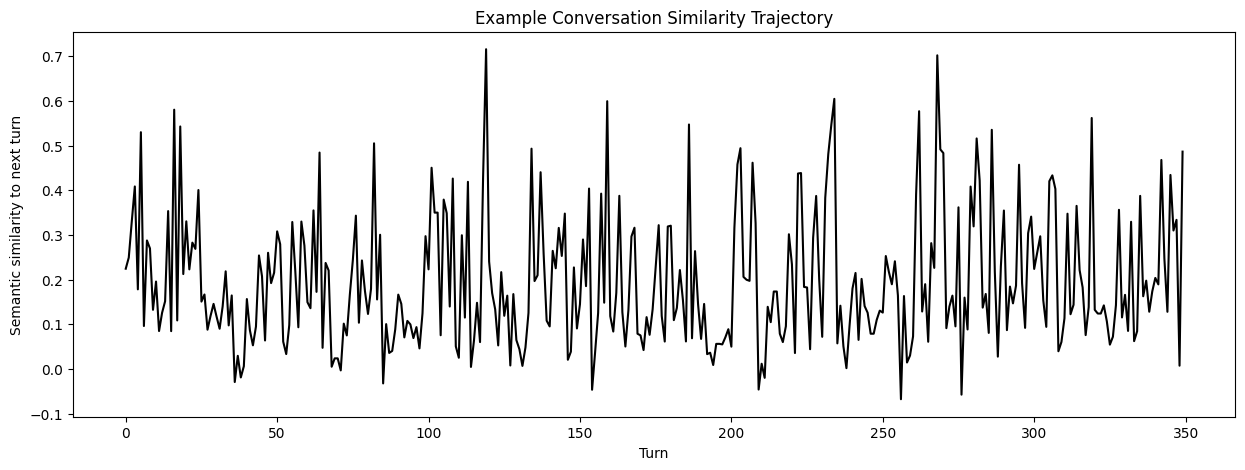

In [7]:
example_embeddings = model.encode(example_turns)
example_trajectory = np.array([1-cosine(example_embeddings[i], example_embeddings[i+1]) for i in range(len(example_embeddings)-1)])
plt.figure(figsize=(15,5))
plt.plot(example_trajectory, color='k')
plt.xlabel('Turn')
plt.ylabel('Semantic similarity to next turn')
plt.title('Example Conversation Similarity Trajectory')
plt.show()

###From here, we use Detrended Fluctuation Analysis (DFA) to estimate the noise scaling coefficient (Hurst coefficient)

####While packages like [MFDFA](https://mfdfa.readthedocs.io/en/latest/) (which we use in the function defined above) are more efficient, let's walk through the DFA algorithm by hand to build intuition



#####First, we subtract the mean from the semantic similarity trajectory then take the cumulative sum to get the profile.

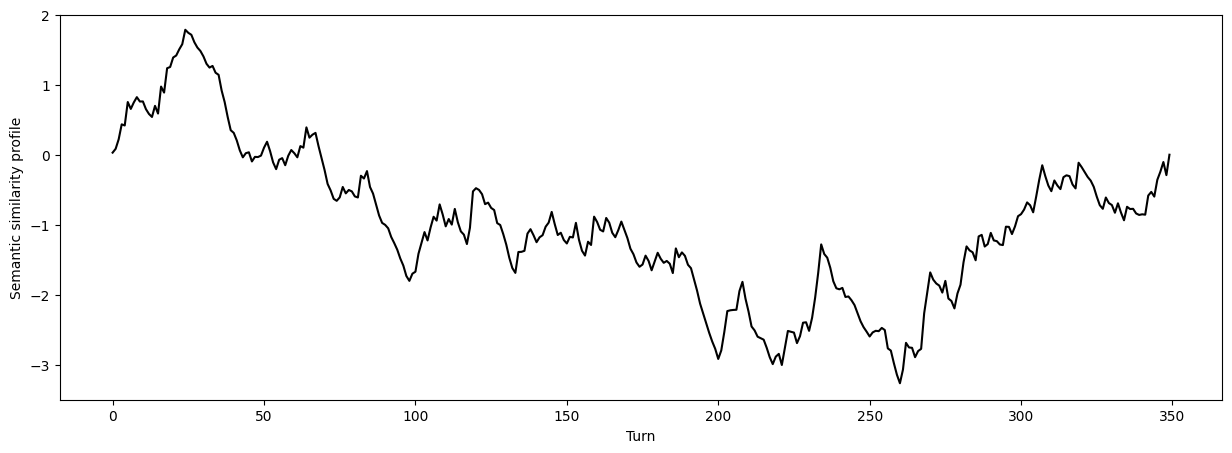

In [8]:
profile = np.cumsum(example_trajectory - np.mean(example_trajectory))
plt.figure(figsize=(15,5))
plt.plot(profile, color='k')
plt.xlabel('Turn')
plt.ylabel('Semantic similarity profile')
plt.ylim(-3.5,2)
plt.show()

#####Second, define a set of integers that scales between 3 and the length of the trajectory that are evenly spaced on a log scale. These integers represent segment lengths.

In [9]:
segment_lengths = np.array([x for x in np.unique(np.logspace(0.5, 3, 100).astype(int)) if x < len(example_trajectory)])
print(segment_lengths)

[  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  24  25  27  28  30  32  34  36  38  40  43  45  48  51  54  57
  61  65  68  73  77  82  86  92  97 103 109 116 123 130 138 146 155 164
 174 185 196 208 220 233 247 262 278 294 312 331]


#####For each segment length, split the cumulative sum of the trajectory into chunks of this length. Within each chunk, define the local trend: the line of best fit through the data.

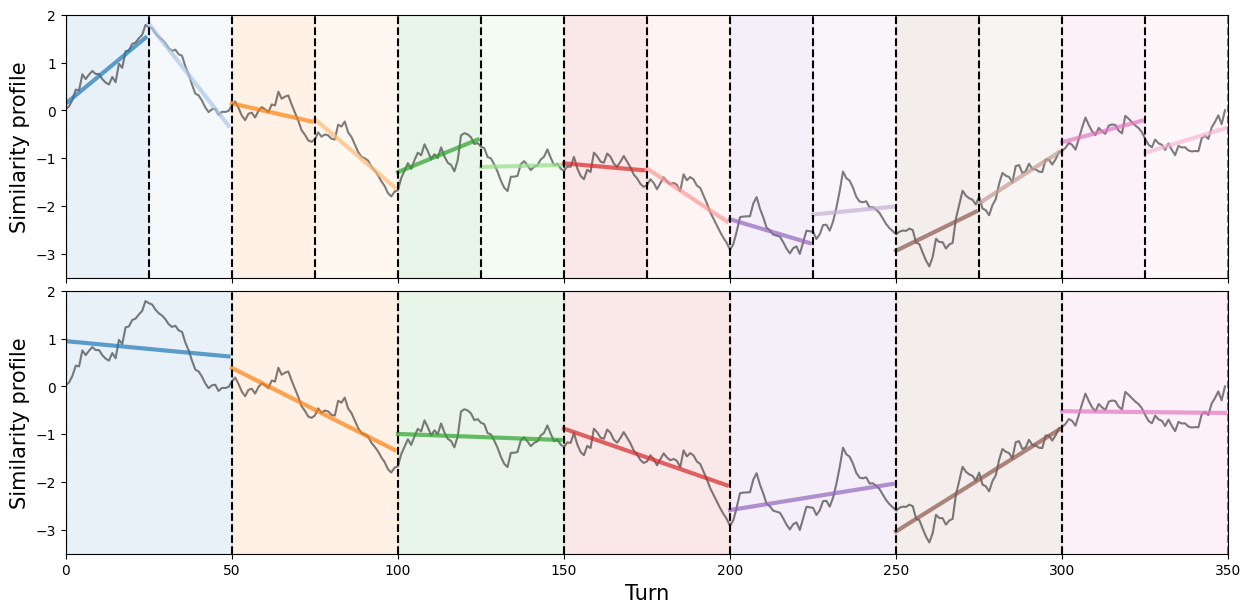

In [10]:
fig, axes = plt.subplots(2,1,figsize=(15,7), sharex=True)
plt.subplots_adjust(hspace=0.05)
colors = [tab20(i) for i in range(0,20,2)] + [tab20(i) for i in range(1,20,2)]
nvals = [25,50]
for j in [0,1,]:
  ax = axes[j]
  n = nvals[j]
  ax.plot(range(len(profile)), profile, color='k', alpha=0.5)
  for i in range(len(profile)//n):
    x = np.array(range(i*n, (i+1)*n))
    chunk = profile[i*n:(i+1)*n]
    m,b = np.polyfit(x,chunk,1)
    ax.plot(x, b+m*x, linewidth=3, alpha=0.7, color=tab20(i*(j+1)))
    ax.vlines(x=i*n,ymin=-3.5,ymax=2, color='k', linestyle='dashed')
    ax.fill_between(x=[i*n, (i+1)*n], y1=[-3.5,-3.5], y2=[2, 2], color=tab20(i*(j+1)), alpha=0.1)
  ax.vlines(x=(i+1)*n,ymin=-3.5,ymax=2, color='k', linestyle='dashed', alpha=0.5)
  ax.set_ylabel('Similarity profile', fontsize=15)
  ax.set_ylim(-3.5, 2)
  ax.set_xlim(0, len(profile))
axes[-1].set_xlabel('Turn', fontsize=15)
plt.show()

##### Then, calculate the local fluctuation for each chunk: the root mean squared difference of the real data from the linear fit.

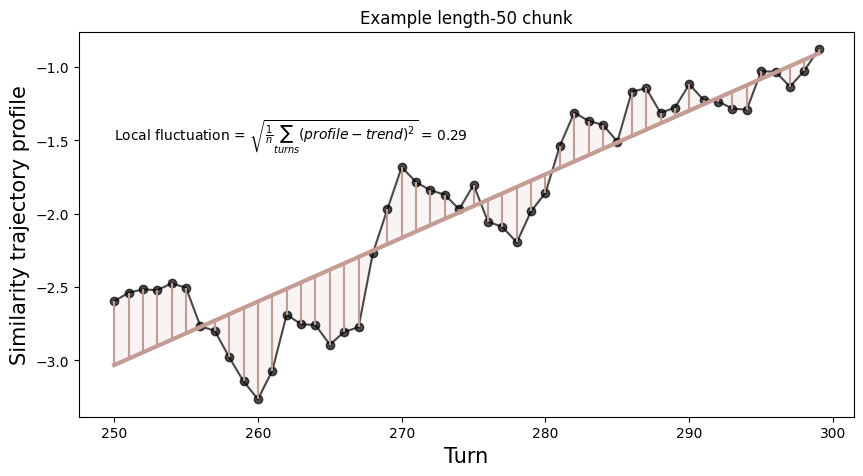

In [11]:
plt.figure(figsize=(10,5))
x = np.array(range(250,300))
chunk = profile[x]
m,b = np.polyfit(x,chunk,1)
predicted = m*x+b
local_fluctuation = np.sqrt(np.mean((predicted-chunk)**2))
plt.plot(x,chunk, color='k', alpha=0.7, marker='o')
plt.plot(x, predicted, color=tab20(11), linewidth=3)
for i in range(len(x)):
  plt.vlines(x=x[i],ymin=min(chunk[i], predicted[i]), ymax=max(chunk[i], predicted[i]), color=tab20(11))

plt.fill_between(x, chunk, predicted, alpha=0.1, color=tab20(11))

plt.xlabel('Turn', fontsize=15)
plt.ylabel('Similarity trajectory profile', fontsize=15)

local_fluctuation = np.sqrt(np.mean((predicted-chunk)**2))
f = '{:.2f}'.format(local_fluctuation)
plt.text(x=250, y=-1.5, s=r'Local fluctuation = $\sqrt{\frac{1}{n}\sum_{turns}(profile-trend)^{2}}$ = '+f)
plt.title('Example length-50 chunk')
plt.show()


##### For each segment length, n, calculate the total fluctuation by taking the root mean square of the local fluctuations. Then plot the fluctuation values and segment lengths against each other on a log-log plot. Essentially, this shows us the relationship between fluctuation and chunk size -- giving us a sense of how the signal's power varies with frequency.


In [12]:
def get_fluctuation(n, profile):
  local_fluctuations = []
  for i in range(len(profile)//n):
    x = np.array(range(i*n, (i+1)*n))
    chunk = profile[i*n:(i+1)*n]
    lr = LinearRegression().fit(x.reshape(-1,1), chunk.reshape(-1,1))
    m = lr.coef_[0][0]
    b = lr.intercept_[0]
    predicted = m*x+b
    local_fluctuation = np.sqrt(np.mean((predicted-chunk)**2))
    local_fluctuations.append(local_fluctuation)
  local_fluctuations = np.array(local_fluctuations)
  total_fluctuation = np.sqrt(np.mean(local_fluctuations**2))
  return total_fluctuation

Text(0, 0.5, 'Log(fluctuation)')

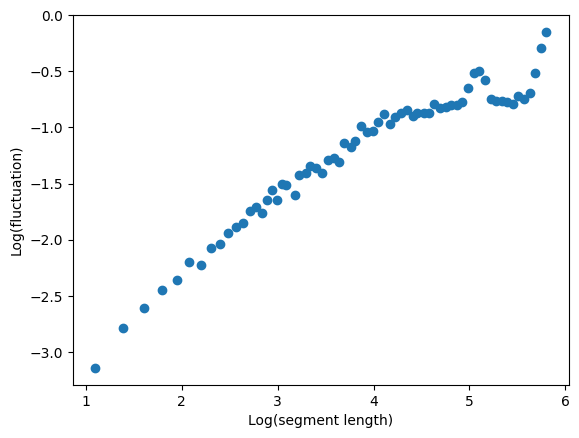

In [13]:
fluctuation = [get_fluctuation(n,profile) for n in segment_lengths]
plt.scatter(np.log(segment_lengths), np.log(fluctuation))

plt.xlabel('Log(segment length)')
plt.ylabel('Log(fluctuation)')

##### Then, take the slope of this plot. Since we'll be comparing signals of many different lengths, let's select points 5 - 20 so we're fitting the linear regression with the same number of data points each time.

Text(0, 0.5, 'Log(fluctuation)')

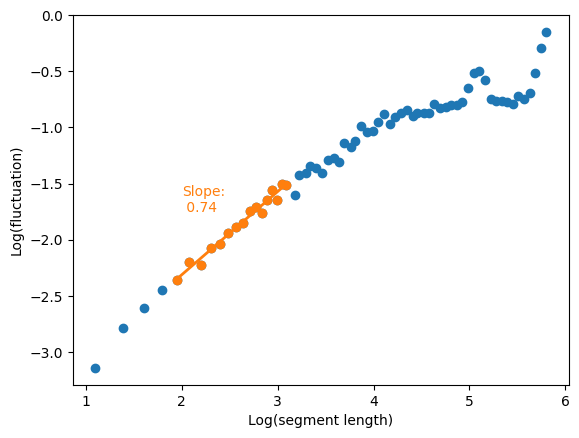

In [14]:
fluctuation = [get_fluctuation(n,profile) for n in segment_lengths]
x = np.log(segment_lengths)[4:20]
y = np.log(fluctuation[4:20])
plt.scatter(np.log(segment_lengths), np.log(fluctuation))
plt.scatter(x,y)

m,b = np.polyfit(x,y,1)
plt.plot(x, b+x*m, color='tab:orange', linewidth=2)
plt.text(x=2, y=-1.75, s='Slope:\n {:.2f}'.format(m), color='tab:orange')

plt.xlabel('Log(segment length)')
plt.ylabel('Log(fluctuation)')

#### Here's the simpler version using MFDFA

(Note that there are some minor differences in fluctuation score for longer segment lengths; this is due to different handling of the leftover data points when a particular chunk length leaves parts of the profile unused)

Text(2, -1.75, 'Slope:\n 0.73')

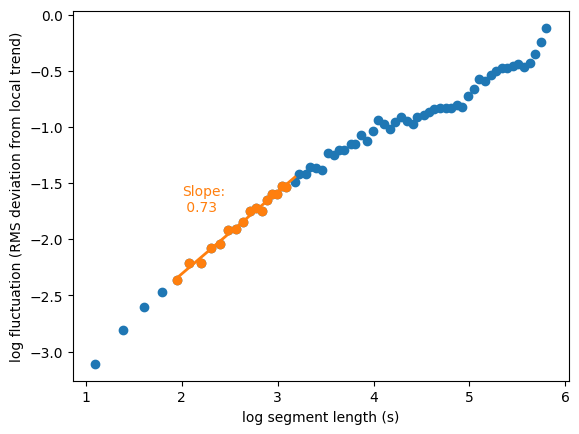

In [15]:
trajectory = example_trajectory
lag = np.array([x for x in np.unique(np.logspace(0.5, 3, 100).astype(int)) if x < len(trajectory)])
q = 2 #monofractal
order = 1
lag, dfa = MFDFA(trajectory, lag = lag, q = q, order = order)
m,b = np.polyfit(np.log(lag)[4:20],np.log(dfa[4:20]),1)
m = m[0]
b = b[0]

plt.scatter(np.log(lag),np.log(dfa))
plt.scatter(np.log(lag)[4:20],np.log(dfa[4:20]))
x = np.array([np.log(lag)[4], np.log(lag)[20]])
plt.plot(x, b+x*m, color='tab:orange', linewidth=2)

plt.xlabel('log segment length (s)')
plt.ylabel('log fluctuation (RMS deviation from local trend)')
plt.text(x=2, y=-1.75, s='Slope:\n {:.2f}'.format(m), color='tab:orange')

### Now that we have the signal's noise scaling coefficient, we can calculate the Pink Noise Robustness score

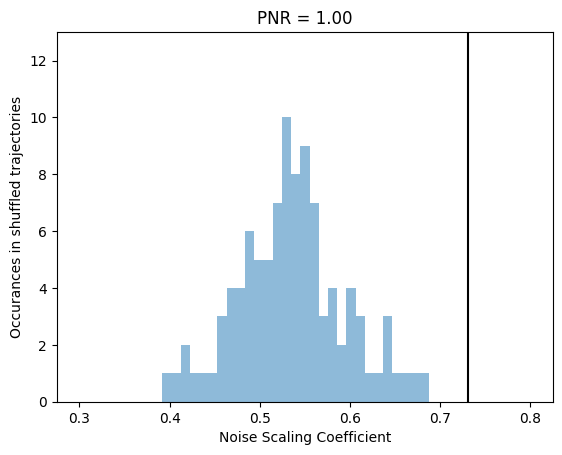

In [16]:
iterations = 100 #note we use 1000 in the paper, but this takes a while to run
hurst = get_noise_scaling_coeff(example_trajectory)
example_trajectory_copy = example_trajectory.copy()

shuffled_hursts = []
for i in range(iterations):
  random.shuffle(example_trajectory_copy)
  shuffled_hursts.append(get_noise_scaling_coeff(example_trajectory_copy))

pnr = np.mean(shuffled_hursts<hurst)

plt.hist(shuffled_hursts, bins = np.linspace(0.3,0.8,50), alpha=0.5)
plt.vlines(x=hurst, ymin=0, ymax=15, color='k')
plt.ylim(0,13)
plt.xlabel('Noise Scaling Coefficient')
plt.ylabel('Occurances in shuffled trajectories')

plt.title('PNR = {:.2f}'.format(pnr))
plt.show()